In [1]:
import sys
import os
sys.path.append('../../')

%load_ext autoreload
%autoreload 2
%matplotlib inline

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
import numpy as np

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import cv2
from skimage.io import imread

from gen.load_data import load_data
from gen.generators import preprocess_label
from keras.models import Model, load_model


/home/faisal/anaconda3/envs/ai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
train_df, valid_df, test_df = load_data('../../data')
test_df.head()

image                   id  \
0  ../../data/Test/CameraRGB/episode_0008_000112.png  episode_0008_000112   
1                ../../data/Test/CameraRGB/00019.png                00019   
2  ../../data/Test/CameraRGB/episode_0012_000130.png  episode_0012_000130   
3  ../../data/Test/CameraRGB/episode_0010_000160.png  episode_0010_000160   
4                ../../data/Test/CameraRGB/00413.png                00413   

                                               label  
0  ../../data/Test/CameraSeg/episode_0008_000112.png  
1                ../../data/Test/CameraSeg/00019.png  
2  ../../data/Test/CameraSeg/episode_0012_000130.png  
3  ../../data/Test/CameraSeg/episode_0010_000160.png  
4                ../../data/Test/CameraSeg/00413.png

In [4]:
import keras.backend as K

K.set_learning_phase(0)
model = load_model('../../saved_models/unet/unet_v6//model_saved.h5')

/home/faisal/anaconda3/envs/ai/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
from keras.applications.vgg16 import  preprocess_input
from keras.preprocessing.image import img_to_array


def load_image(img_path, label_path):
    img = imread(img_path)
    lbl  = preprocess_label(imread(label_path))
    x = cv2.resize(preprocess_input(img_to_array(imread(img_path)[184:, :, :])), (544, 416))
    
    return img, lbl, x

def predict(model, img):
    result = model.predict(np.expand_dims(x, 0))
    p_img = result[0].argmax(axis=-1)
    
    car = np.zeros((600, 800))
    road = np.zeros((600, 800))
    
    car[184:, :] = cv2.resize((p_img == 0).astype(np.uint8), (800, 416))
    road[184:, :] = cv2.resize((p_img == 1).astype(np.uint8), (800, 416))
    
    lbl = np.zeros((600, 800))
    lbl[car.nonzero()] = 1
    lbl[road.nonzero()] = 2
    
    return car, road, lbl


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


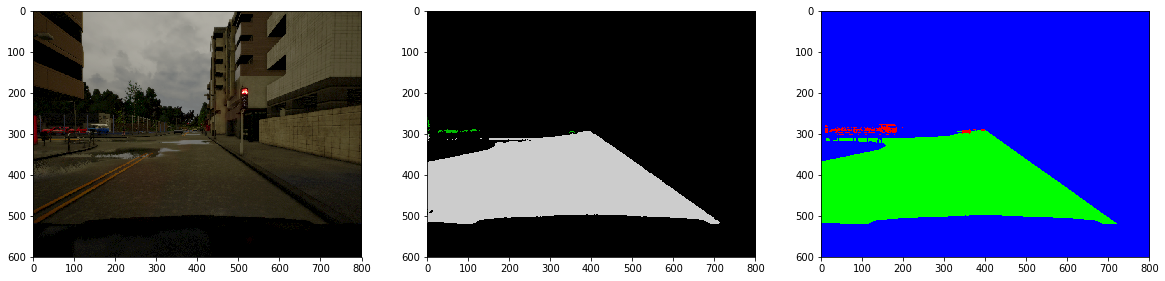

In [7]:
s = valid_df.loc[np.random.randint(0, valid_df.shape[0])]
img, lbl, x = load_image(s[0], s[2])

_, _, output = predict(model, x)

plt.figure(figsize=(20, 10))
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(output, cmap='nipy_spectral')
plt.subplot(133)
plt.imshow(lbl*255)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

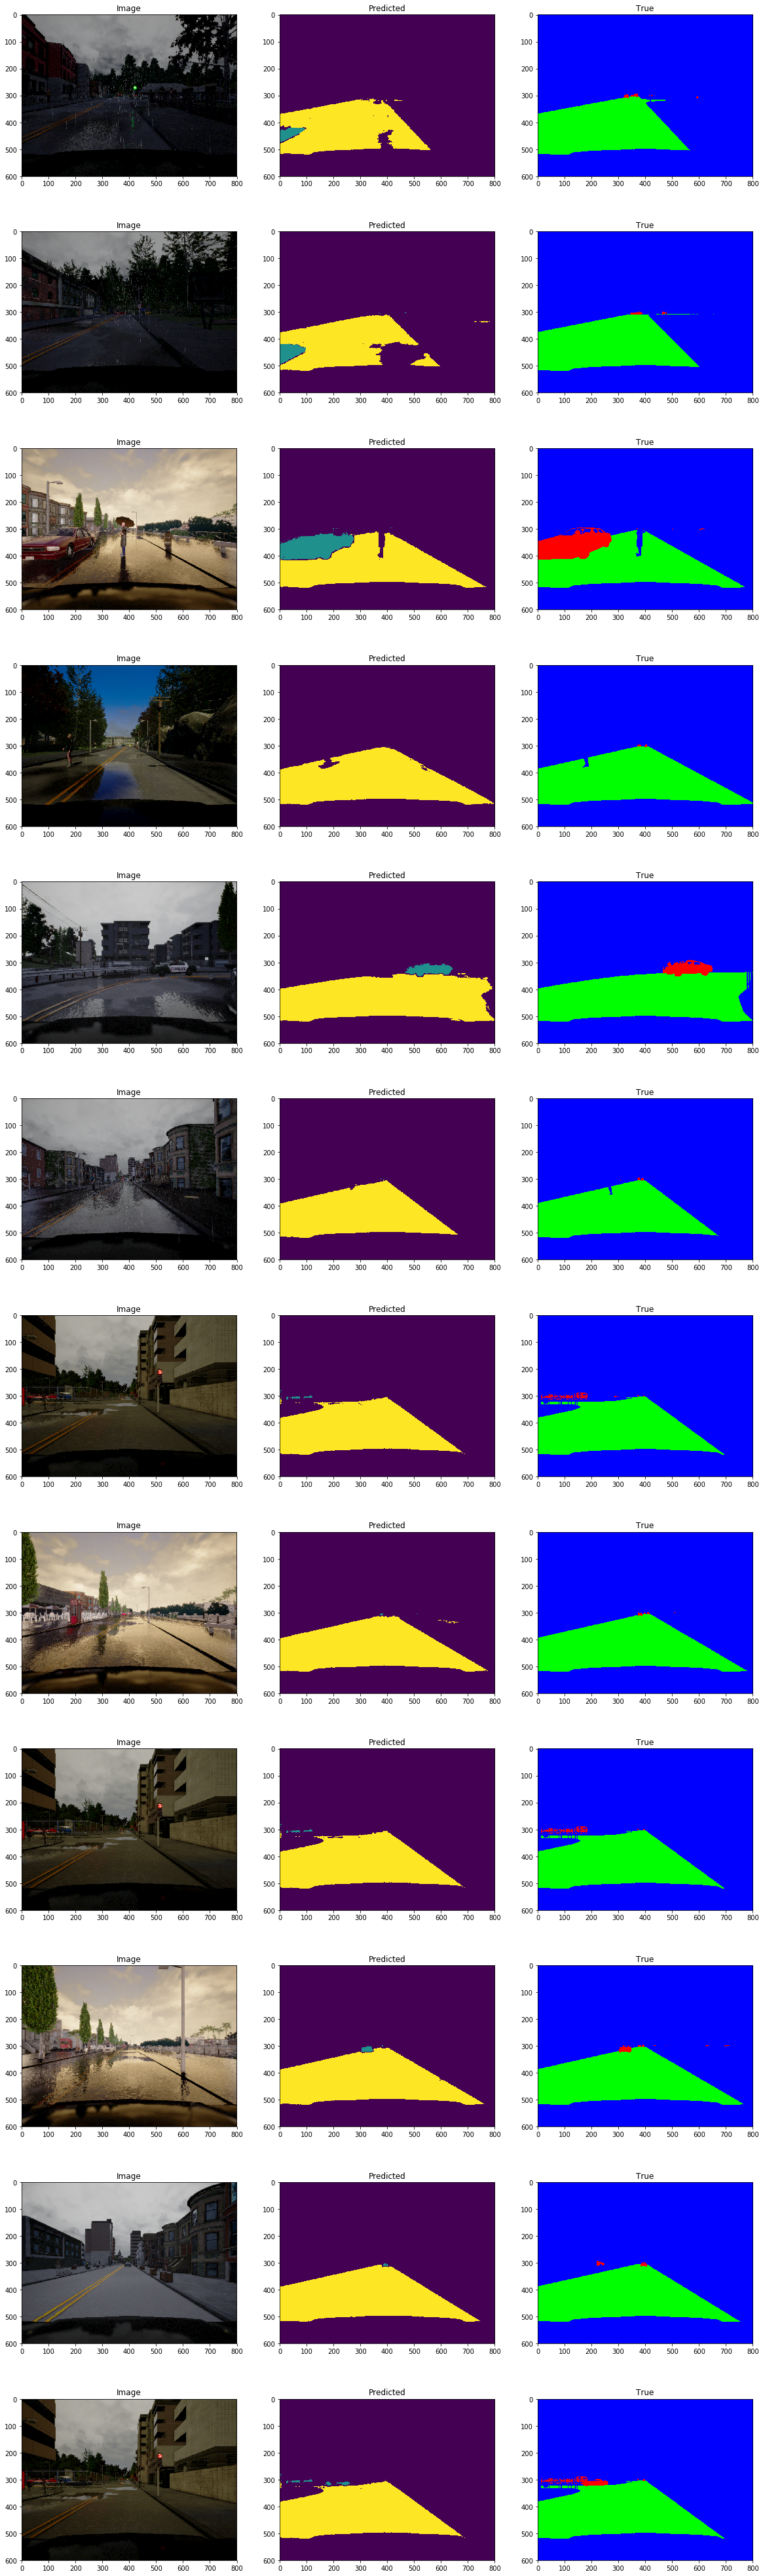

In [8]:
sample_rows = 12

fig, m_axs = plt.subplots(sample_rows, 3, figsize = (20, 6*sample_rows))
for (ax1, ax2, ax3), (_, c_row) in zip(m_axs, valid_df.sample(sample_rows).iterrows()):
    img, lbl, x = load_image(c_row['image'], c_row['label'])
    _, _, output = predict(model, img)
    
    ax1.imshow(img)
    ax1.set_title('Image')    
    ax2.imshow(output,)
    ax2.set_title('Predicted')
    ax3.imshow(lbl*255)
    ax3.set_title('True')

In [9]:
def scoreIt(student_data_car, student_data_road, truth_data_car, truth_data_road):        
    Car_TP = 0 # True Positives
    Car_FP = 0 # Flase Positives
    Car_TN = 0 # True Negatives
    Car_FN = 0 # True Negatives

    Road_TP = 0 # True Positives
    Road_FP = 0 # Flase Positives
    Road_TN = 0 # True Negatives
    Road_FN = 0 # True Negatives

    Car_TP += np.sum(np.logical_and(student_data_car == 1, truth_data_car == 1)) + np.e
    Car_FP += np.sum(np.logical_and(student_data_car == 1, truth_data_car == 0)) + np.e
    Car_TN += np.sum(np.logical_and(student_data_car == 0, truth_data_car == 0)) + np.e
    Car_FN += np.sum(np.logical_and(student_data_car == 0, truth_data_car == 1)) + np.e
    
    Road_TP += np.sum(np.logical_and(student_data_road == 1, truth_data_road == 1)) + np.e
    Road_FP += np.sum(np.logical_and(student_data_road == 1, truth_data_road == 0)) + np.e
    Road_TN += np.sum(np.logical_and(student_data_road == 0, truth_data_road == 0))+  np.e
    Road_FN += np.sum(np.logical_and(student_data_road == 0, truth_data_road == 1))+  np.e
    
    Car_precision = Car_TP/(Car_TP+Car_FP)/1.0
    Car_recall = Car_TP/(Car_TP+Car_FN)/1.0
    Car_beta = 2.0
    Car_F = (1+Car_beta**2) * ((Car_precision*Car_recall)/(Car_beta**2.0 * Car_precision + Car_recall))
    Road_precision = Road_TP/(Road_TP+Road_FP)/1.0
    Road_recall = Road_TP/(Road_TP+Road_FN)/1.0
    Road_beta = 0.5
    Road_F = (1+Road_beta**2.0) * ((Road_precision*Road_recall)/(Road_beta**2.0 * Road_precision + Road_recall))
    
    return (Car_F + Road_F)/2.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.9214150822288143


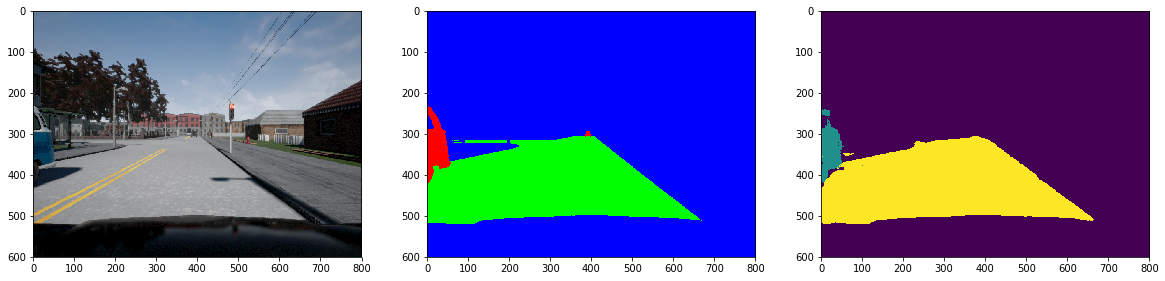

In [18]:
ind = np.random.randint(0, 30)
img, lbl, x = load_image(valid_df.loc[ind].image, valid_df.loc[ind].label)
car, road, output = predict(model, x)

score = scoreIt(car, road, lbl[:, :, 0], lbl[:, :, 1])

print (score)
plt.figure(figsize=(20, 20))
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(lbl*255)
plt.subplot(133)
plt.imshow(output)

In [19]:
inds = []
scores = []

i = 0
for _, row in valid_df.iterrows():
    img, lbl, x = load_image(row.image, row.label)
    car, road, output = predict(model, x)
    score = scoreIt(car, road, lbl[:, :, 0], lbl[:, :, 1])
    scores.append(score)
    inds.append(row.id)

In [20]:
c = sorted(zip(scores, inds))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.38807474252976826 00468
0.39438885956614933 00467


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.41075442100617204 00469
0.418843834876169 00466


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.43313755007691573 00465
0.4389157649877632 00470


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.44416217244517725 00464
0.4559892385562196 00463


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.46707006026144055 00462
0.4702462301990117 00461


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.472396563355006 episode_0004_000091
0.4752842355043346 episode_0004_000089


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.4770643410233395 episode_0004_000077


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.4780036766326721 episode_0004_000083
0.47934969681374523 00471


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.48023922498929916 episode_0004_000088
0.4805366474365687 episode_0004_000087


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.4807942218421915 episode_0004_000105
0.481916665470771 episode_0004_000090


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.4820386233058899 episode_0004_000106


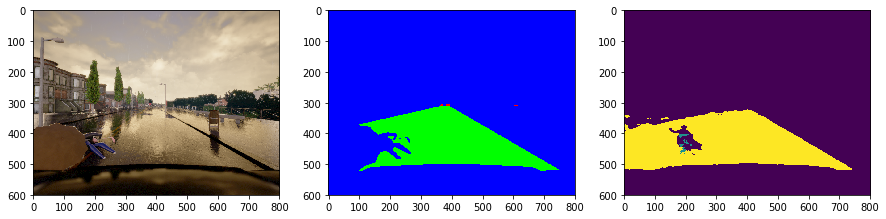

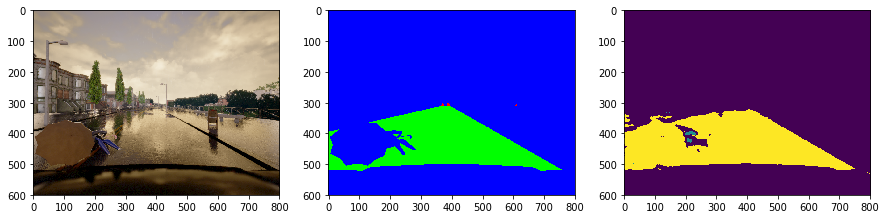

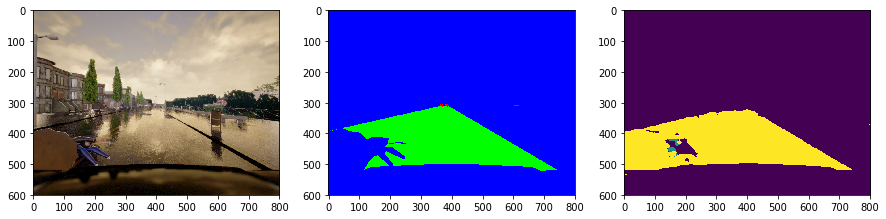

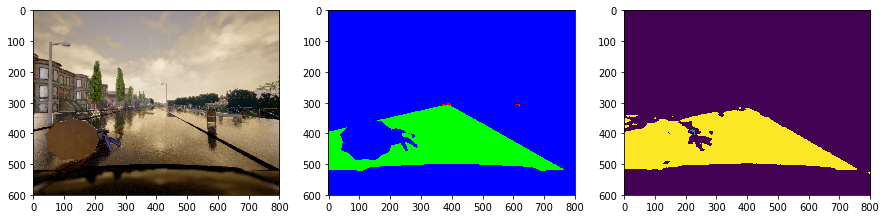

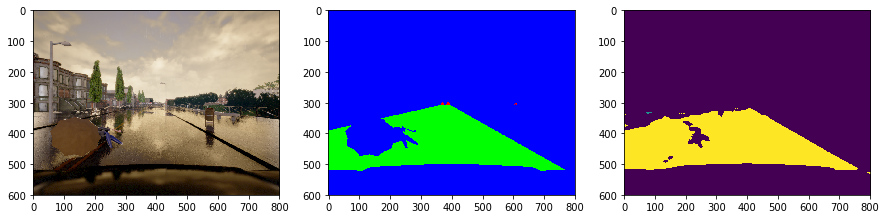

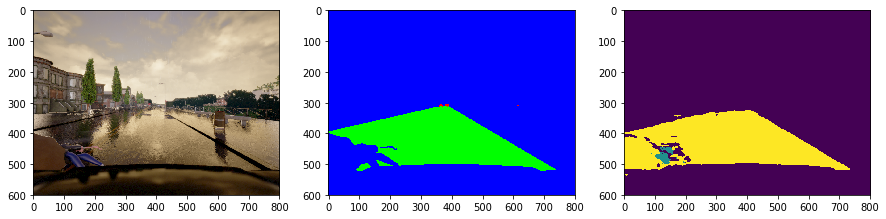

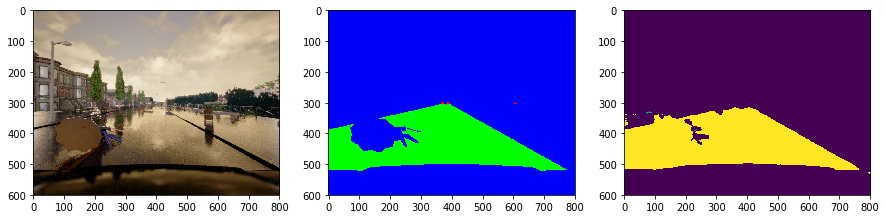

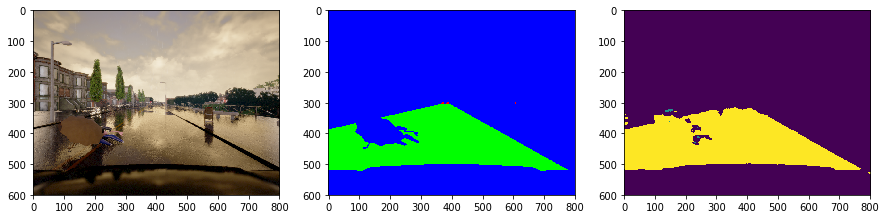

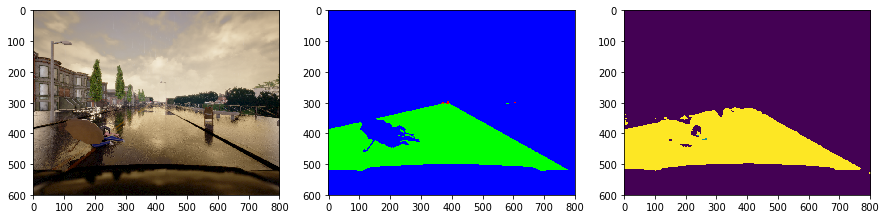

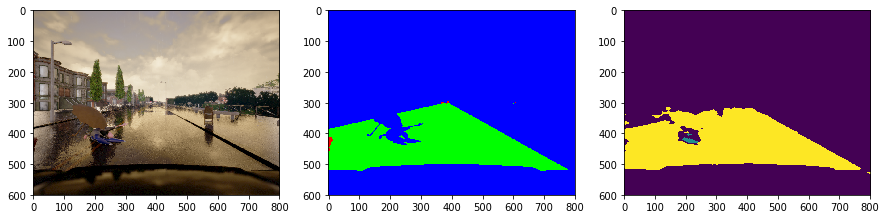

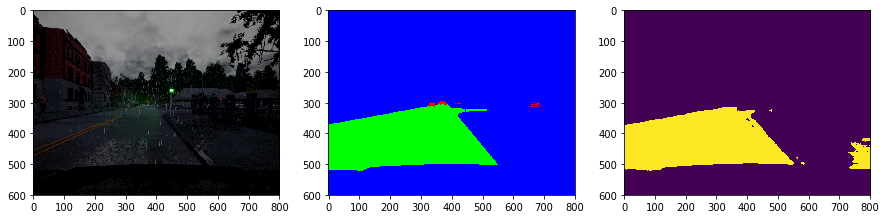

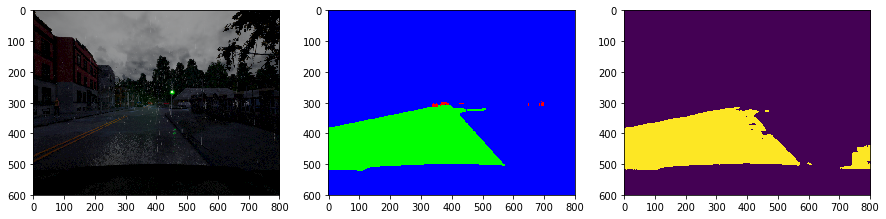

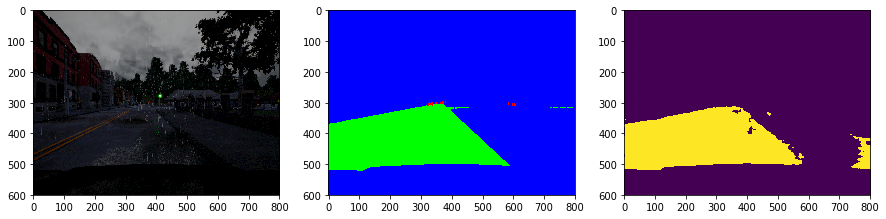

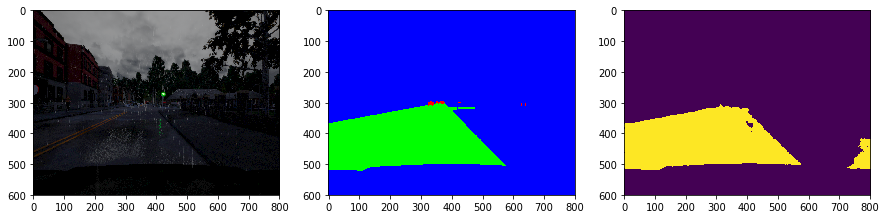

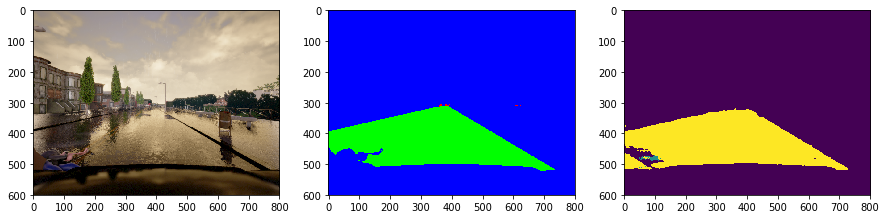

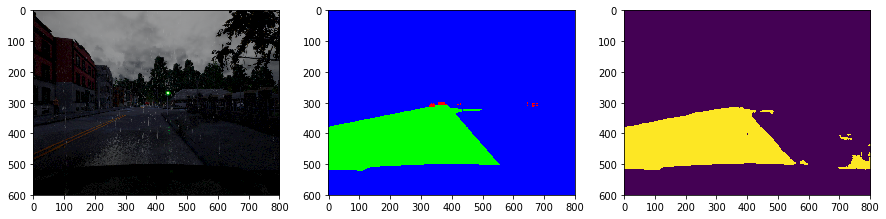

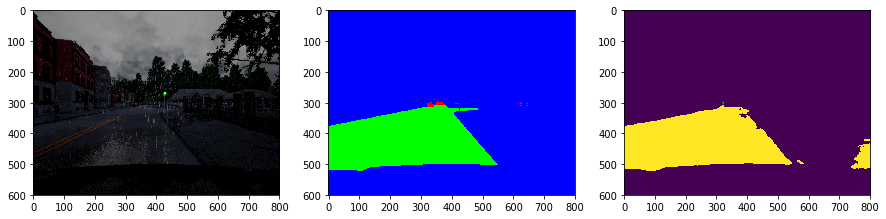

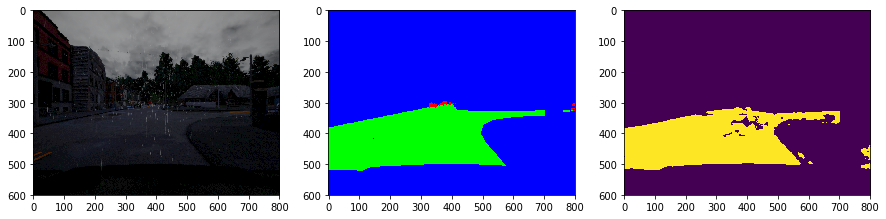

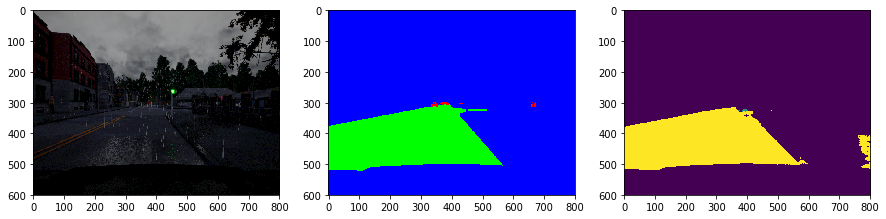

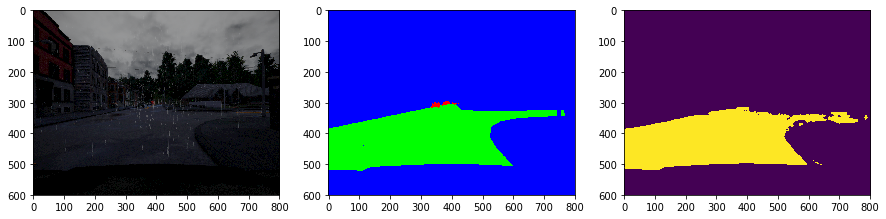

In [24]:
sample = c[0:20]
for s, i in sample:
    print (s, i)
    pt = valid_df[valid_df.id == i]
    img, lbl, x = load_image(pt.image.values[0], pt.label.values[0])
    _, _, output = predict(model, x)
    
    plt.figure(figsize=(15, 15))
    plt.subplot(131)
    plt.imshow(img)
    plt.subplot(132)
    plt.imshow(lbl*255)
    plt.subplot(133)
    plt.imshow(output)

In [ ]:
print (test_df.loc[217].image)

In [ ]:
plt.figure(figsize=(20, 20))
plt.subplot(141)
plt.imshow(outputs[217][1])
plt.subplot(142)
plt.imshow(outputs[217][2]*255)
plt.subplot(143)
plt.imshow(outputs[217][3]*255)
plt.subplot(144)
plt.imshow(outputs[217][4]*255)

In [ ]:
probs = outputs[407][0][0]
print (probs[0, 0, 0], probs[0, 0, 1], probs[0, 0, 2])

In [ ]:
plt.imshow(probs[:, :, 0] > 0.9)

In [ ]:
plt.imshow(probs[:, :, 1])